In [1]:
import collections
import gymnasium as gym
import numpy as np
import statistics
import tensorflow as tf
import tqdm

from matplotlib import pyplot as plt
from tensorflow.keras import layers
from typing import Any, List, Sequence, Tuple


# Create the environment
env = gym.make('MountainCar-v0').env

# Set seed for experiment reproducibility
# seed = 42
# tf.random.set_seed(seed)
# np.random.seed(seed)

# to be able to evaluate tensors
# tf.config.run_functions_eagerly(True)

# Small epsilon value for stabilizing division operations
eps = np.finfo(np.float32).eps.item()

In [2]:
class ActorCritic(tf.keras.Model):
    """Combined actor-critic network."""

    def __init__(
            self,
            input_shape,
            num_actions: int,
            num_hidden_units: int):
        """Initialize."""
        super().__init__()

        # self.common = tf.keras.Sequential(
        #     [layers.Dense(num_hidden_units, activation="relu", input_shape=input_shape),
        #      layers.Dense(num_hidden_units, activation="relu")])
        self.common = layers.Dense(num_hidden_units,
                                   activation="relu",
                                   input_shape=input_shape)
        self.actor = layers.Dense(num_actions)
        self.critic = layers.Dense(1)

    def call(self, inputs: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
        x = self.common(inputs)
        return self.actor(x), self.critic(x)

In [3]:
input_shape = env.observation_space.shape
num_actions = env.action_space.n  # 3
num_hidden_units = 128

print('num_actions:', num_actions)
print('input_shape:', input_shape)
print('num_hidden_units:', num_hidden_units)

model = ActorCritic(input_shape, num_actions, num_hidden_units)

num_actions: 3
input_shape: (2,)
num_hidden_units: 128


In [4]:
# Wrap Gym's `env.step` call as an operation in a TensorFlow function.
# This would allow it to be included in a callable TensorFlow graph.

def env_step(action: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Returns state, reward and done flag given an action."""

    state, reward, done, truncated, info = env.step(action)
    return (state.astype(np.float32), 
                    np.array(reward, np.int32), 
                    np.array(done, np.int32))


def tf_env_step(action: tf.Tensor) -> List[tf.Tensor]:
    return tf.numpy_function(env_step, [action], [tf.float32, tf.int32, tf.int32])

In [5]:
def run_episode_debug(
        initial_state: tf.Tensor,    
        model: tf.keras.Model) -> Tuple[tf.Tensor, tf.Tensor, tf.Tensor]:
    """Runs a single episode to collect training data."""

    states = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
    actions = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    action_probs = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
    action_probs_all = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
    values = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
    rewards = tf.TensorArray(dtype=tf.int32, size=0, dynamic_size=True)

    initial_state_shape = initial_state.shape
    state = initial_state

    for t in tf.range(1_000):

        # Convert state into a batched tensor (batch size = 1)
        state = tf.expand_dims(state, 0)
    
        # Run the model and to get action probabilities and critic value
        action_logits_t, value = model(state)
    
        # Sample next action from the action probability distribution
        action = tf.random.categorical(action_logits_t, 1)[0, 0]
        actions = actions.write(t, action)
        
        action_probs_t = tf.nn.softmax(action_logits_t)

        # Store critic values
        values = values.write(t, tf.squeeze(value))

        # Store log probability of the action chosen
        action_probs = action_probs.write(t, action_probs_t[0, action])
        action_probs_all = action_probs_all.write(t, tf.squeeze(action_probs_t))
    
        # Apply action to the environment to get next state and reward
        state, reward, done = tf_env_step(action)
        state.set_shape(initial_state_shape)
        states = states.write(t, tf.squeeze(state))

        # Store reward
        rewards = rewards.write(t, reward)

        if tf.cast(done, tf.bool):
            break

    states = states.stack()
    actions = actions.stack()
    action_probs = action_probs.stack()
    action_probs_all = action_probs_all.stack()
    values = values.stack()
    rewards = rewards.stack()
    
    return states, actions, action_probs, action_probs_all, values, rewards

In [6]:
def run_episode(initial_state: tf.Tensor, model: tf.keras.Model,
                max_steps: int) -> Tuple[tf.Tensor, tf.Tensor, tf.Tensor]:
    """Runs a single episode to collect training data."""

    action_probs = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
    values = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
    rewards = tf.TensorArray(dtype=tf.int32, size=0, dynamic_size=True)

    initial_state_shape = initial_state.shape
    state = initial_state

    for t in tf.range(max_steps):

        # Convert state into a batched tensor (batch size = 1)
        state = tf.expand_dims(state, 0)

        # Run the model and to get action probabilities and critic value
        action_logits_t, value = model(state)

        # Sample next action from the action probability distribution
        action = tf.random.categorical(action_logits_t, 1)[0, 0]
        action_probs_t = tf.nn.softmax(action_logits_t)

        # Store critic values
        values = values.write(t, tf.squeeze(value))

        # Store log probability of the action chosen
        action_probs = action_probs.write(t, action_probs_t[0, action])

        # Apply action to the environment to get next state and reward
        state, reward, done = tf_env_step(action)
        state.set_shape(initial_state_shape)

        # Store reward
        rewards = rewards.write(t, reward)

        if tf.cast(done, tf.bool):
            break

    action_probs = action_probs.stack()
    values = values.stack()
    rewards = rewards.stack()

    return action_probs, values, rewards

In [7]:
def get_expected_return(
    rewards: tf.Tensor, 
    values: tf.Tensor, 
    gamma: float, 
    standardize: bool = True) -> tf.Tensor:
    """Compute expected returns per timestep."""

    n = tf.shape(rewards)[0]
    returns = tf.TensorArray(dtype=tf.float32, size=n)

    # Start from the end of `rewards` and accumulate reward sums
    # into the `returns` array
    rewards = tf.cast(rewards[::-1], dtype=tf.float32)
    #values = tf.concat([values, tf.zeros((1))], 0)
    #values = tf.cast(values[::-1], dtype=tf.float32)
    discounted_sum = tf.constant(0.0)
    discounted_sum_shape = discounted_sum.shape
    for i in tf.range(n):
        reward = rewards[i]
        discounted_sum = reward + gamma * discounted_sum
        discounted_sum.set_shape(discounted_sum_shape)
        returns = returns.write(i, discounted_sum)
    returns = returns.stack()[::-1]

    if standardize:
        returns = ((returns - tf.math.reduce_mean(returns)) / 
                   (tf.math.reduce_std(returns) + eps))
    
    return returns

In [8]:
huber_loss = tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.SUM)

def compute_loss(
    action_probs: tf.Tensor,  
    values: tf.Tensor,  
    returns: tf.Tensor) -> tf.Tensor:
    """Computes the combined Actor-Critic loss."""
    
    advantage = returns - values
    
    action_log_probs = tf.math.log(action_probs)
    actor_loss = -tf.math.reduce_sum(action_log_probs * advantage)

    critic_loss = huber_loss(values, returns)

    return actor_loss + critic_loss

In [9]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)


@tf.function
def train_step(
    initial_state: tf.Tensor, 
    model: tf.keras.Model, 
    optimizer: tf.keras.optimizers.Optimizer, 
    gamma: float,
    max_steps: int) -> tf.Tensor:
    """Runs a model training step."""

    with tf.GradientTape() as tape:

        # Run the model for one episode to collect training data
        action_probs, values, rewards = run_episode(initial_state, model, max_steps) 

        # Calculate the expected returns
        returns = get_expected_return(rewards, values, gamma)

        # Convert training data to appropriate TF tensor shapes
        action_probs, values, returns = [
                tf.expand_dims(x, 1) for x in [action_probs, values, returns]] 

        # Calculate the loss values to update our network
        loss = compute_loss(action_probs, values, returns)

    # Compute the gradients from the loss
    grads = tape.gradient(loss, model.trainable_variables)

    # Apply the gradients to the model's parameters
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    episode_reward = tf.math.reduce_sum(rewards)

    return action_probs, episode_reward

In [10]:
# %%time

min_episodes_criterion = 100
max_episodes = 10_000
max_steps_per_episode = 10_000
reward_threshold = -200
running_reward = 0

# The discount factor for future rewards
gamma = 0.99

# Keep the last episodes reward
episodes_reward: collections.deque = collections.deque(
    maxlen=min_episodes_criterion)

t = tqdm.trange(max_episodes)
for i in t:
    initial_state, info = env.reset()
    initial_state = tf.constant(initial_state, dtype=tf.float32)
    action_probs, episode_reward = train_step(initial_state, model, optimizer,
                                              gamma, max_steps_per_episode)
    episode_reward = int(episode_reward)

    episodes_reward.append(episode_reward)
    running_reward = statistics.mean(episodes_reward)

    t.set_postfix(R_e=episode_reward, R_avg=running_reward)

    if running_reward > reward_threshold and i >= min_episodes_criterion:
        break

print(f'\nSolved at episode {i}: average reward: {running_reward:.2f}!')

 25%|██▍       | 2463/10000 [05:28<16:45,  7.50it/s, R_avg=-199, R_e=-224]      


Solved at episode 2463: average reward: -199.22!


In [11]:
# Render an episode and save as a GIF file

from IPython import display as ipythondisplay
from PIL import Image

render_env = gym.make("MountainCar-v0", render_mode='rgb_array').env


def render_episode(env: gym.Env, model: tf.keras.Model, max_steps: int):
    state, info = env.reset()
    state = tf.constant(state, dtype=tf.float32)
    screen = env.render()
    images = [Image.fromarray(screen)]
    states = []
    action_probs_all = []
    actions = []

    for i in range(1, max_steps + 1):
        state = tf.expand_dims(state, 0)
        states.append(np.squeeze(state[0]))
        action_probs, _ = model(state)
        action_probs_all.append(np.squeeze(tf.nn.softmax(action_probs)))
        action = np.argmax(np.squeeze(action_probs))
        actions.append(action)

        state, reward, done, truncated, info = env.step(action)
        state = tf.constant(state, dtype=tf.float32)

        # Render screen every 10 steps
        if i % 2 == 0:
            screen = env.render()
            images.append(Image.fromarray(screen))

        if done:
            break

    return images, np.array(states), np.array(action_probs_all), np.array(
        actions)


# Save GIF image
images, states, action_probs_all, actions = render_episode(
    render_env, model, max_steps_per_episode)
image_file = 'mountaincar-v0.gif'
# loop=0: loop forever, duration=1: play each frame for 1ms
images[0].save(image_file,
               save_all=True,
               append_images=images[1:],
               loop=0,
               duration=1)



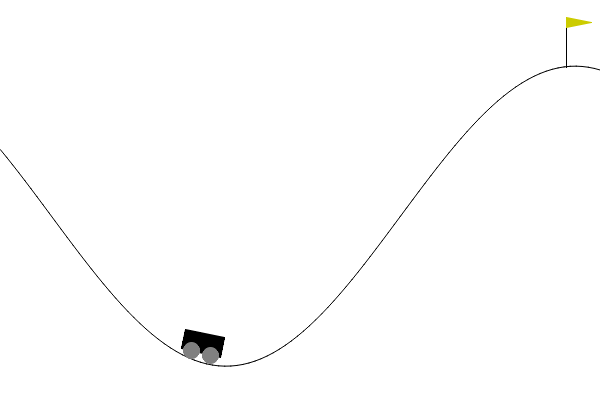

In [12]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(image_file)


/var/folders/yd/b6rjh5td65z6fb_m9r3kcmb80000gn/T/ipykernel_55493/4275823749.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_yticklabels(yticklabels)


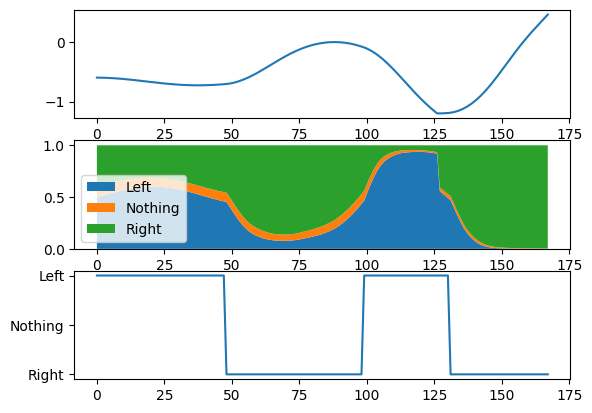

In [13]:
labels = ['Left', 'Nothing', 'Right']
fig, axs = plt.subplots(3,1)
x = np.arange(action_probs_all.shape[0])
axs[0].plot(states[:,0])
axs[1].stackplot(x,
              action_probs_all[:, 0],
              action_probs_all[:, 1],
              action_probs_all[:, 2],
              labels=labels)
axs[1].legend(loc=3)
axs[2].plot(-1* (actions - 1))
yticklabels = axs[2].get_yticklabels()
for ticklabel, label in zip(yticklabels[1:-1], labels[::-1]):
    ticklabel.set(text=label)
axs[2].set_yticklabels(yticklabels)
plt.show()